# PINT Pulsar Timing Analysis: CTCV J2056-3014
### *To view plots, visit [nbviewer](https://nbviewer.org/github/ericymiao/ctcvj2056-timing-spin-evolution/blob/main/notebooks/04_pint_analysis.ipynb)*

Precision timing analysis using PINT (a Pulsar Timing package) to measure spin frequency (F0) and its time derivative (F1 = dF/dt).

## What is Pulsar Timing?

Pulsar timing measures the arrival times of pulses (TOAs) and fits a timing model to predict when each pulse should arrive. Deviations from the model (residuals) reveal:
- Errors in the assumed period or period derivative
- Orbital motion (if in a binary)
- Astrometric effects (proper motion, parallax)

For this white dwarf pulsar, we fit:
- **F0**: The spin frequency (~0.0338 Hz, corresponding to P ~ 29.6 s)
- **F1**: The frequency derivative (dF/dt), related to spin-up or spin-down

The period derivative Pdot = -F1/F0^2 tells us whether the WD is spinning up (Pdot < 0, accreting angular momentum) or spinning down (Pdot > 0, losing angular momentum).

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import copy
import pandas as pd
from scipy import linalg, stats
from statsmodels.nonparametric.smoothers_lowess import lowess

import astropy.units as u
from astropy.time import Time, TimeDelta

import pint.models
from pint.models import model_builder
from pint.models import PhaseOffset
import pint.toa
import pint.simulation
import pint.residuals
from pint.fitter import DownhillWLSFitter, WLSFitter
from pint.toa import get_TOAs_list

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pint.logging
pint.logging.setup(level="WARNING")

plt.rcParams.update({
    'font.size': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'figure.constrained_layout.use': True,
})

savedir = '../paper_figures'

## Load Model and TOAs

In [2]:
# Load timing model and TOAs
model, toas = model_builder.get_model_and_toas(
    "../data/initial_timing_model.par", 
    "../data/toas.tim"
)

print(f"Loaded {len(toas)} TOAs")
print(f"MJD range: {toas.get_mjds().min():.2f} - {toas.get_mjds().max():.2f}")
print()
print(model)

Loaded 5 TOAs
MJD range: 58780.58 d - 60554.68 d

# Created: 2026-02-20T19:40:55.835373
# PINT_version: 1.1.3
# User: ericmiao
# Host: MacBook-Pro-760.local
# OS: macOS-26.0.1-x86_64-i386-64bit-Mach-O
# Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 11:09:21) [Clang 14.0.6 ]
# Format: pint
# read_time: 2026-02-20T19:40:55.806023
# allow_tcb: False
# convert_tcb: False
# allow_T2: False
# original_name: ../data/initial_timing_model.par
EPHEM                               DE440
UNITS                                 TDB
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
RAJ                     20:56:52.15000000
DECJ                   -30:14:39.10000000
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                             0.03377273
F1                                    0.0 1 0.0
PEPOCH             59460.0000000

## Pre-fit Residuals

Residuals are the difference between observed TOAs and model-predicted TOAs. Before fitting F0 and F1, residuals may show systematic trends indicating the initial model is imperfect. Large residuals or clear patterns suggest the need to fit additional parameters.

Pre-fit RMS: 3675132.9560 us


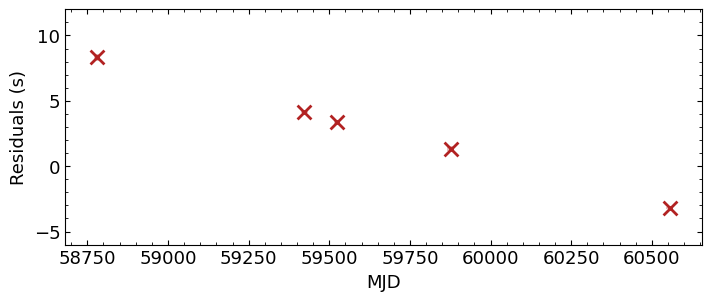

In [14]:
# Calculate pre-fit residuals
res = pint.residuals.Residuals(toas, model, subtract_mean=False)

times = res.toas.get_mjds().value
res_vals = res.time_resids.to(u.s).value
err_vals = res.toas.get_errors().to(u.s).value

fig, ax = plt.subplots(figsize=(7, 2.9))

ax.scatter(times, res_vals, marker='x', s=100, linewidths=2, color='firebrick', zorder=5)
ax.bar(times, height=2*err_vals, bottom=res_vals-err_vals, width=20,
       alpha=0.3, color='firebrick', edgecolor='none')
ax.set_ylim(-6, 12)

ax.set_xlabel('MJD')
ax.set_ylabel('Residuals (s)')

print(f"Pre-fit RMS: {res.rms_weighted():.4f}")

fig.savefig(f'{savedir}/pint_prefit_resids.pdf')
plt.show()

## Fit F0 and F1

We unfreeze F0 (frequency) and F1 (frequency derivative) and perform a weighted least-squares fit to minimize residuals. The fitter adjusts these parameters to best match the observed TOAs.

In [4]:
# Unfreeze F0 and F1 for fitting
model.F0.frozen = False
model.F1.frozen = False

# Add phase offset component to handle phase ambiguity
# This ensures simulated TOAs align with real TOAs
po = PhaseOffset()
model.add_component(po)
model.PHOFF.frozen = False

fitter = DownhillWLSFitter(toas, model)
fitter.fit_toas()

print(fitter.print_summary())

Fitted model using downhill_wls method with 3 free parameters to 5 TOAs
Prefit residuals Wrms = 3675132.9560335204 us, Postfit residuals Wrms = 46467.02247069241 us
Chisq = 0.869 for 1 d.o.f. for reduced Chisq of 0.869

PAR                   Prefit                  Postfit            Units
============== ==================== ============================ =====
EPHEM                         DE440 DE440                        None
CLOCK                               TT(BIPM2023)                 None
UNITS                           TDB TDB                          None
START                                                    58780.6 d 
FINISH                                                   60554.7 d 
DILATEFREQ                        N                              None
DMDATA                            N                              None
NTOA                              0                              None 
CHI2                                                     0.86942  
CHI2R         

## Post-fit Residuals

Post-fit RMS: 46467.0225 us
Reduced chi2: 0.869


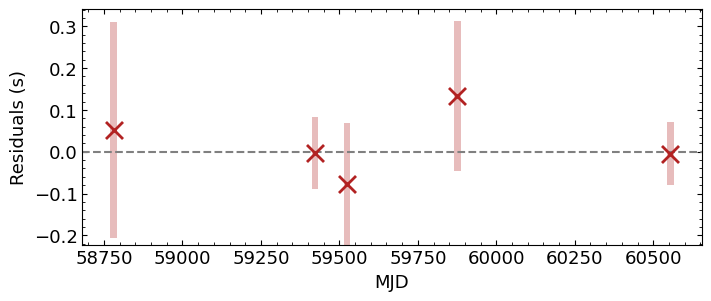

In [5]:
# Plot post-fit residuals
times = fitter.resids.toas.get_mjds().value
residuals = fitter.resids.time_resids.to(u.s).value
err = fitter.resids.toas.get_errors().to(u.s).value

fig, ax = plt.subplots(figsize=(7, 2.9))

ax.scatter(times, residuals, marker='x', s=150, linewidths=2, color='firebrick', zorder=5)
ax.bar(times, height=2*err, bottom=residuals-err, width=20,
       alpha=0.3, color='firebrick', edgecolor='none')
ax.axhline(0, color='gray', ls='--')

ax.set_xlabel('MJD')
ax.set_ylabel('Residuals (s)')

print(f"Post-fit RMS: {fitter.resids.rms_weighted():.4f}")
print(f"Reduced chi2: {fitter.resids.chi2_reduced:.3f}")

fig.savefig(f'{savedir}/pint_postfit_resids.pdf')
plt.show()

## Parameter Correlation

F0 and F1 are highly correlated (|r| ~ 0.92) because, over a limited time baseline, a small change in F0 can partially compensate for a change in F1. This is a fundamental degeneracy in pulsar timing:

- A slightly higher F0 with negative F1 can produce similar TOAs as a slightly lower F0 with positive F1
- **Longer baselines break this degeneracy** because the cumulative effect of F1 grows as t^2, eventually dominating over the linear F0 term

The correlation coefficient r ~ -0.92 means the uncertainties are highly coupled, and the marginal uncertainty on F1 (from the diagonal of the covariance matrix) is much larger than the conditional uncertainty (F1 given a known F0).

In [6]:
# Get correlation matrix and uncertainties
# With PHOFF added, we have 3 free parameters - extract F0-F1 submatrix
param_labels = fitter.parameter_correlation_matrix.labels

# Extract just the parameter names from the nested structure
param_names = [label[0] for label in param_labels[0]]
print(f"Fitted parameters: {param_names}")

# Find indices of F0 and F1 in the correlation matrix
f0_idx = param_names.index('F0')
f1_idx = param_names.index('F1')

# Extract F0-F1 correlation submatrix
full_corr = fitter.parameter_correlation_matrix.matrix
corr = np.array([[full_corr[f0_idx, f0_idx], full_corr[f0_idx, f1_idx]],
                 [full_corr[f1_idx, f0_idx], full_corr[f1_idx, f1_idx]]])

sigmas = np.array([fitter.get_fitparams_uncertainty()[p] for p in ['F0', 'F1']])

print(f"\nF0-F1 Correlation matrix:\n{corr}")
print(f"\nF0 uncertainty: {sigmas[0]:.6e} Hz")
print(f"F1 uncertainty: {sigmas[1]:.6e} Hz/s")
print(f"\nCorrelation coefficient: {corr[0,1]:.4f}")

Fitted parameters: ['F0', 'F1', 'PHOFF']

F0-F1 Correlation matrix:
[[ 1.         -0.91915073]
 [-0.91915073  1.        ]]

F0 uncertainty: 8.676633e-11 Hz
F1 uncertainty: 1.992811e-18 Hz/s

Correlation coefficient: -0.9192


## Error Ellipse

The error ellipse visualizes the joint uncertainty in F0 and F1:

- **Ellipse orientation**: The tilt shows the correlation direction. A negative correlation means the ellipse tilts from upper-left to lower-right.
- **Ellipse shape**: A skinny ellipse indicates high correlation. The major axis shows the direction of maximum uncertainty (the degenerate direction), while the minor axis shows the well-constrained direction.
- **Shaded rectangles**: Show the marginal 1-sigma uncertainties projected onto each axis. Notice these are larger than the ellipse extent along the minor axis - this is because the marginal uncertainty includes the full range of correlated values.

The 1/2/3-sigma ellipses enclose 39.3%, 86.5%, and 98.9% of the probability, respectively.

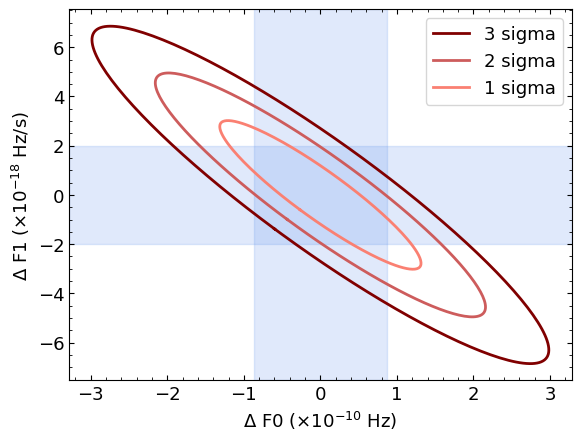

In [25]:
# Eigenvalue decomposition for ellipse
vals, vecs = linalg.eigh(corr)

# Scale factors for display
x_scale = 1e-10  # Delta F0
y_scale = 1e-18  # Delta F1

fig, ax = plt.subplots(figsize=(5.7, 4.3))

# Draw 1, 2, 3 sigma ellipses
colors = {1: 'salmon', 2: 'indianred', 3: 'maroon'}
for n_sigma in [3, 2, 1]:
    thresh = np.sqrt(stats.chi2(2).isf(2 * stats.norm.cdf(-n_sigma)))
    angles = np.linspace(0, 2 * np.pi, 200)
    points = thresh * (
        np.sqrt(vals[0]) * np.cos(angles)[:, None] * vecs[None, :, 0]
        + np.sqrt(vals[1]) * np.sin(angles)[:, None] * vecs[None, :, 1]
    )
    ax.plot(points[:, 0] * sigmas[0] / x_scale,
            points[:, 1] * sigmas[1] / y_scale,
            label=f"{n_sigma} sigma", color=colors[n_sigma], lw=2)

# Add marginal uncertainty boxes (shaded regions)
x_sigma = sigmas[0] / x_scale
y_sigma = sigmas[1] / y_scale

ax.axvspan(-x_sigma, x_sigma, alpha=0.2, color='cornflowerblue')
ax.axhspan(-y_sigma, y_sigma, alpha=0.2, color='cornflowerblue')

ax.set_xlabel(r'$\Delta$ F0 ($\times 10^{-10}$ Hz)')
ax.set_ylabel(r'$\Delta$ F1 ($\times 10^{-18}$ Hz/s)')
ax.legend(loc='upper right')

fig.savefig(f'{savedir}/pint_error_ellipse.pdf')
plt.show()

## Future Observation Planning

**When will we detect F1 (and thus Pdot)?**

We simulate future TOAs assuming a non-zero F1 (set to the current 1-sigma upper limit) and ask: at what point does F1 become significantly detected (>3 sigma)?

The simulation:
1. Generates fake TOAs at future dates with realistic uncertainties
2. Combines them with existing TOAs
3. Fits for F0 and F1
4. Calculates the significance |F1|/sigma_F1

As the baseline grows, the F0-F1 degeneracy breaks and F1 significance increases. The plot shows when we expect to cross the 3-sigma detection threshold.

In [75]:
# Simulate with non-zero F1 to see when it becomes detectable
model_simulate = copy.deepcopy(fitter.model)
model_simulate.F1.quantity = 8e-19  # 1-sigma Pdot
model_simulate.F0.frozen = False
model_simulate.F1.frozen = False

# Create future TOAs
start_mjd = 60600
end_mjd = 64000
num_toas = 100
toas_future = pint.simulation.make_fake_toas_uniform(
    start_mjd, end_mjd, num_toas, 
    error=0.16*u.s, model=model_simulate, add_noise=True
)

# Combine with existing TOAs
toas_combined = copy.deepcopy(toas_future)
toas_combined.merge(toas)

print(f"Simulated {num_toas} future TOAs from MJD {start_mjd} to {end_mjd}")
print(f"Combined dataset: {len(toas_combined)} TOAs")

Simulated 100 future TOAs from MJD 60600 to 64000
Combined dataset: 105 TOAs


In [ ]:
# Visualize simulated + current TOAs together
res_current = pint.residuals.Residuals(toas, fitter.model, subtract_mean=False)
res_future = pint.residuals.Residuals(toas_future, fitter.model, subtract_mean=False)

print(f"Current TOAs residuals (s): {res_current.time_resids.to(u.s).value}")
print(f"Current TOAs mean residual: {res_current.time_resids.to(u.s).value.mean():.2f} s")
print(f"Future TOAs mean residual: {res_future.time_resids.to(u.s).value.mean():.2f} s")
print(f"Future TOAs residual range: {res_future.time_resids.to(u.s).value.min():.2f} to {res_future.time_resids.to(u.s).value.max():.2f} s")

mjds_current = res_current.toas.get_mjds().value
res_current_vals = res_current.time_resids.to(u.s).value
err_current = res_current.toas.get_errors().to(u.s).value

mjds_future_plot = res_future.toas.get_mjds().value
res_future_vals = res_future.time_resids.to(u.s).value
err_future = res_future.toas.get_errors().to(u.s).value

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(mjds_current, res_current_vals, marker='x', s=150, linewidths=3,
           color='firebrick', label='Current TOAs', zorder=5)
ax.bar(mjds_current, height=2*err_current, bottom=res_current_vals-err_current, width=20,
       alpha=0.3, color='firebrick', edgecolor='none')

ax.scatter(mjds_future_plot, res_future_vals, marker='x', s=100, linewidths=2,
           color='darkviolet', alpha=0.6, label='Simulated TOAs')
ax.bar(mjds_future_plot, height=2*err_future, bottom=res_future_vals-err_future, width=20,
       alpha=0.2, color='darkviolet', edgecolor='none')

ax.axhline(0, color='gray', ls='--')
ax.set_xlabel('MJD')
ax.set_ylabel('Residuals (s)')
ax.legend(loc='top left')
plt.show()

In [94]:
# Calculate F1 significance for each TOA in the combined dataset
# Use model_simulate (with F1=8e-19) for fitting - it has better initial values
sigs = []

for toa in toas_combined[:-5]:
    toas_test = get_TOAs_list(toas.to_TOA_list() + [toa.to_TOA_list()[0]])
    
    # Use model_simulate which has F1=8e-19 as starting point
    model_simulate.F0.frozen = False
    model_simulate.F1.frozen = False
    
    fit = DownhillWLSFitter(toas_test, model_simulate)
    try:
        fit.fit_toas()
        sig = np.abs(fit.model.F1.value / fit.model.F1.uncertainty.value)
    except:
        sig = np.nan
    sigs.append(sig)

sigs = np.array(sigs)
print(f"Calculated F1 significance for {len(sigs)} TOAs")

Calculated F1 significance for 100 TOAs


In [ ]:
# Plot F1 significance vs time
mjds = toas_combined.get_mjds()[:-5]
t = Time(mjds, format='mjd')
datetime_values = pd.to_datetime(t.to_datetime())

# LOWESS smoothing
valid = ~np.isnan(sigs)
smoothed = lowess(sigs[valid], mjds[valid], frac=0.3)
t_smooth = Time(smoothed[:, 0], format='mjd')
smoothed_dates = pd.to_datetime(t_smooth.to_datetime())

fig, ax = plt.subplots(figsize=(6.4, 3.6))

ax.scatter(datetime_values[valid], sigs[valid], marker='x', s=100,
           linewidths=2, color='darkviolet', alpha=0.6)
ax.plot(smoothed_dates, smoothed[:, 1], color='firebrick', lw=3)

# 3-sigma detection threshold
ax.axhline(3, color='gray', ls='--', lw=2)

# Mark current Pdot constraint
current_mjd = toas.get_mjds().max()
current_datetime = pd.to_datetime(Time(current_mjd, format='mjd').to_datetime())
ax.axvline(current_datetime, color='cornflowerblue', ls=':', lw=2)

ax.set_xlabel('Observation Date')
ax.set_ylabel(r'F1 Significance ($\sigma$)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.savefig(f'{savedir}/pint_f1_detectability.pdf')
plt.show()

## Upper Limit if F1 = 0

**What constraints can we place if there is no spin evolution?**

Under the null hypothesis (F1 = 0, no period change), we simulate future observations and calculate how tight the Pdot constraint becomes over time. This tells us:

- The current upper limit on |Pdot| from existing data
- How the constraint improves with longer baselines
- When we can rule out physically interesting Pdot values (e.g., those expected from accretion torques)

The Pdot uncertainty scales roughly as t^(-3/2) for well-sampled data, so constraints improve rapidly with baseline.

In [79]:
# Simulate with F1 = 0
model_null = copy.deepcopy(fitter.model)
model_null.F1.quantity = 0
model_null.F0.frozen = False
model_null.F1.frozen = False

start_mjd_null = 60600
end_mjd_null = 68000
toas_null = pint.simulation.make_fake_toas_uniform(
    start_mjd_null, end_mjd_null, 150,
    error=0.16*u.s, model=model_null, add_noise=True
)

# Combine with existing TOAs for visualization
toas_null_combined = copy.deepcopy(toas_null)
toas_null_combined.merge(toas)

print(f"Simulated {len(toas_null)} future TOAs from MJD {start_mjd_null} to {end_mjd_null}")
print(f"Combined dataset: {len(toas_null_combined)} TOAs")

Simulated 150 future TOAs from MJD 60600 to 68000
Combined dataset: 155 TOAs


In [ ]:
# Visualize simulated TOAs (F1=0) + current TOAs
res_current_null = pint.residuals.Residuals(toas, fitter.model, subtract_mean=False)
res_null_future = pint.residuals.Residuals(toas_null, fitter.model, subtract_mean=False)

mjds_current_null = res_current_null.toas.get_mjds().value
res_current_null_vals = res_current_null.time_resids.to(u.s).value
err_current_null = res_current_null.toas.get_errors().to(u.s).value

mjds_null_future = res_null_future.toas.get_mjds().value
res_null_future_vals = res_null_future.time_resids.to(u.s).value
err_null_future = res_null_future.toas.get_errors().to(u.s).value

print(f"Current TOAs mean: {res_current_null_vals.mean():.2f} s, Future TOAs mean: {res_null_future_vals.mean():.2f} s")

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(mjds_current_null, res_current_null_vals, marker='x', s=150, linewidths=3,
           color='firebrick', label='Current TOAs', zorder=5)
ax.bar(mjds_current_null, height=2*err_current_null, bottom=res_current_null_vals-err_current_null, width=20,
       alpha=0.3, color='firebrick', edgecolor='none')

ax.scatter(mjds_null_future, res_null_future_vals, marker='x', s=100, linewidths=2,
           color='cornflowerblue', alpha=0.6, label='Simulated TOAs')
ax.bar(mjds_null_future, height=2*err_null_future, bottom=res_null_future_vals-err_null_future, width=20,
       alpha=0.2, color='cornflowerblue', edgecolor='none')

ax.axhline(0, color='gray', ls='--')
ax.set_xlabel('MJD')
ax.set_ylabel('Residuals (s)')
ax.legend(loc='upper right')
plt.show()

In [96]:
# Calculate Pdot constraint for each TOA in the combined dataset
# Use model_null (with F1=0) for fitting
constraints = []

for toa in toas_null_combined[:-5]:
    toas_test = get_TOAs_list(toas.to_TOA_list() + [toa.to_TOA_list()[0]])
    
    # Use model_null which has F1=0 as starting point
    model_null.F0.frozen = False
    model_null.F1.frozen = False
    
    fit = DownhillWLSFitter(toas_test, model_null)
    try:
        fit.fit_toas()
        # Convert F1 uncertainty to Pdot: Pdot = -F1/F0^2
        constraint = np.abs(fit.model.F1.uncertainty.value / (fit.model.F0.value ** 2))
    except:
        constraint = np.nan
    constraints.append(constraint)

constraints = np.array(constraints)
print(f"Calculated Pdot constraints for {len(constraints)} TOAs")

Calculated Pdot constraints for 150 TOAs


In [ ]:
# Plot Pdot constraint vs time
mjds_null = toas_null_combined.get_mjds()[:-5]
t_null = Time(mjds_null, format='mjd')
datetime_null = pd.to_datetime(t_null.to_datetime())

# LOWESS smoothing
valid = ~np.isnan(constraints)
smoothed_c = lowess(constraints[valid], mjds_null[valid], frac=0.1)
t_smooth_c = Time(smoothed_c[:, 0], format='mjd')
smoothed_dates_c = pd.to_datetime(t_smooth_c.to_datetime())

fig, ax = plt.subplots(figsize=(6.4, 3.6))

ax.scatter(datetime_null[valid], constraints[valid], marker='x', s=100,
           linewidths=2, color='darkviolet', alpha=0.6)
ax.plot(smoothed_dates_c, smoothed_c[:, 1], color='firebrick', lw=3)

# Mark current constraint
current_mjd = toas.get_mjds().max()
current_datetime = pd.to_datetime(Time(current_mjd, format='mjd').to_datetime())
ax.axvline(current_datetime, color='cornflowerblue', ls=':', lw=2)

ax.set_xlabel('Observation Date')
ax.set_ylabel(r'1-$\sigma$ $\dot{P}$ (s/s)')
ax.set_ylim(0, 1.8e-15)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.savefig(f'{savedir}/pint_pdot_constraint.pdf')
plt.show()

## Random Model Simulations

To visualize how timing uncertainties propagate into the future, we generate random timing models by sampling from the covariance matrix of the fitted parameters. Each random model represents a plausible set of (F0, F1) values consistent with the data.

For each model, we calculate the phase at future times. The spread of phases shows:
- How timing predictions become uncertain at future epochs
- The "fan" pattern where uncertainty grows with time from the reference epoch
- The standard deviation at each epoch gives the expected phase uncertainty

In [83]:
# Create fake TOAs for simulation
start_mjd = 60600
end_mjd = 64000
tnew = pint.simulation.make_fake_toas_uniform(
    start_mjd, end_mjd, 100, 
    error=0.16*u.s, model=fitter.model
)

# Generate random models from covariance
n_models = 300
dphase, random_models = pint.simulation.calculate_random_models(
    fitter, tnew, Nmodels=n_models
)

print(f"Generated {n_models} random models")

Generated 300 random models


In [ ]:
# Plot model deviations
fig, ax1 = plt.subplots(figsize=(5.7, 3.6))

for i in range(min(250, n_models)):
    ax1.plot(tnew.get_mjds(), dphase[i][:].value.tolist(), alpha=0.3, color='darkviolet', lw=0.5)

ax1.set_xlabel('MJD')
ax1.set_ylabel('Phase deviation')

fig.savefig(f'{savedir}/pint_random_models.pdf')
plt.show()

# Plot standard deviation
fig, ax2 = plt.subplots(figsize=(5.7, 3.6))

sd = dphase.std(axis=0).value
ax2.plot(tnew.get_mjds(), sd, lw=3, color='firebrick')

ax2.set_xlabel('MJD')
ax2.set_ylabel('Phase SD')

fig.savefig(f'{savedir}/pint_phase_uncertainty.pdf')
plt.show()